In [1]:
# importing the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
# get the training data and save it in a dataframe.
df= pd.read_excel("Data_Train_Flight_Price_Prediction.xlsx")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.shape

(10683, 11)

In [65]:
# get the test data and save it in a dataframe.
df_test= pd.read_excel("Test_set_Flight_Price_Prediction.xlsx")
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [5]:
df_test.shape

(2671, 10)

In [6]:
# get the basic information about the columns and their data-type.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
# check the number of missing values for each column.
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [8]:
# impute the missing values with mode.
df['Route']=df['Route'].fillna(df['Route'].mode()[0])
df['Total_Stops']=df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])

In [9]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [10]:
# check for duplicates.
df.duplicated().value_counts()

# There are 220 duplicate entries.

False    10463
True       220
dtype: int64

In [11]:
# dropping the duplicate entries.
df.drop_duplicates(inplace=True,ignore_index=True)

In [12]:
# Convert the 'Date_of_Journey' column to datetime format and extract the Day and Month into separate columns.
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y',dayfirst=True)
df['Day_of_month']= df['Date_of_Journey'].dt.day
df['Month']= df['Date_of_Journey'].dt.month
df.drop(columns=['Date_of_Journey'],inplace=True)

In [13]:
# drop the 'Arrival_Time' column as we already have departure time and flight duration.
df.drop(columns=['Arrival_Time'],inplace=True)

In [14]:
# Convert the 'Dep_Time' column to datetime format and convert it to 24 hours format of float-datatype
df['Dep_Time']=pd.to_datetime(df['Dep_Time'],format='%H:%M')
x=df['Dep_Time'].dt.hour+df['Dep_Time'].dt.minute/60
df['Dep_Time']=x
df.head()

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_month,Month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22.333333,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,5.833333,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,9.416667,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18.083333,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16.833333,4h 45m,1 stop,No info,13302,1,3


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10463 non-null  object 
 1   Source           10463 non-null  object 
 2   Destination      10463 non-null  object 
 3   Route            10463 non-null  object 
 4   Dep_Time         10463 non-null  float64
 5   Duration         10463 non-null  object 
 6   Total_Stops      10463 non-null  object 
 7   Additional_Info  10463 non-null  object 
 8   Price            10463 non-null  int64  
 9   Day_of_month     10463 non-null  int64  
 10  Month            10463 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 899.3+ KB


In [16]:
# The h and m in duration data is removed and only numerics are extracted to a list in string format.
duratn=[]
for i in range(len(df['Duration'])):
    components= df['Duration'][i].strip().split(" ")
    if len(components)==2:
        hour= components[0].split("h")[0]
        minute=components[1].split("m")[0]
        duratn.append(hour+'.'+minute)
    elif (len(components)==1) & (components[0].find("h")!=(-1)):
        hour= components[0].split("h")[0]
        minute=str(0)
        duratn.append(hour+'.'+minute)
    elif (len(components)==1) & (components[0].find("m")!=(-1)):
        hour=str(0)
        minute=components[0].split("m")[0]
        duratn.append(hour+'.'+minute)
    else:
        duratn.append(df['Duration'][i])
        
duratn[0:10]

['2.50',
 '7.25',
 '19.0',
 '5.25',
 '4.45',
 '2.25',
 '15.30',
 '21.5',
 '25.30',
 '7.50']

In [17]:
# duration data is converted to numeric format.
df['Duration']= pd.to_numeric(duratn)

In [18]:
# The data in 'Total_Stops' column is in string format. 
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [19]:
# encoding the data using replace function.
df['Total_Stops'].replace({'non-stop':0, 
                           '1 stop':1, 
                           '2 stops':2, 
                           '3 stops':3, 
                           '4 stops':4},inplace=True)
df['Total_Stops'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10463 non-null  object 
 1   Source           10463 non-null  object 
 2   Destination      10463 non-null  object 
 3   Route            10463 non-null  object 
 4   Dep_Time         10463 non-null  float64
 5   Duration         10463 non-null  float64
 6   Total_Stops      10463 non-null  int64  
 7   Additional_Info  10463 non-null  object 
 8   Price            10463 non-null  int64  
 9   Day_of_month     10463 non-null  int64  
 10  Month            10463 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 899.3+ KB


In [21]:
# Check the unique values in 'Additional_Info' column.
df['Additional_Info'].unique()

# There are two unique values representing no info.

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [22]:
# replacing one with the other.
df['Additional_Info'].replace("No Info","No info",inplace=True)
df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

# Let us see some plots of our dataset

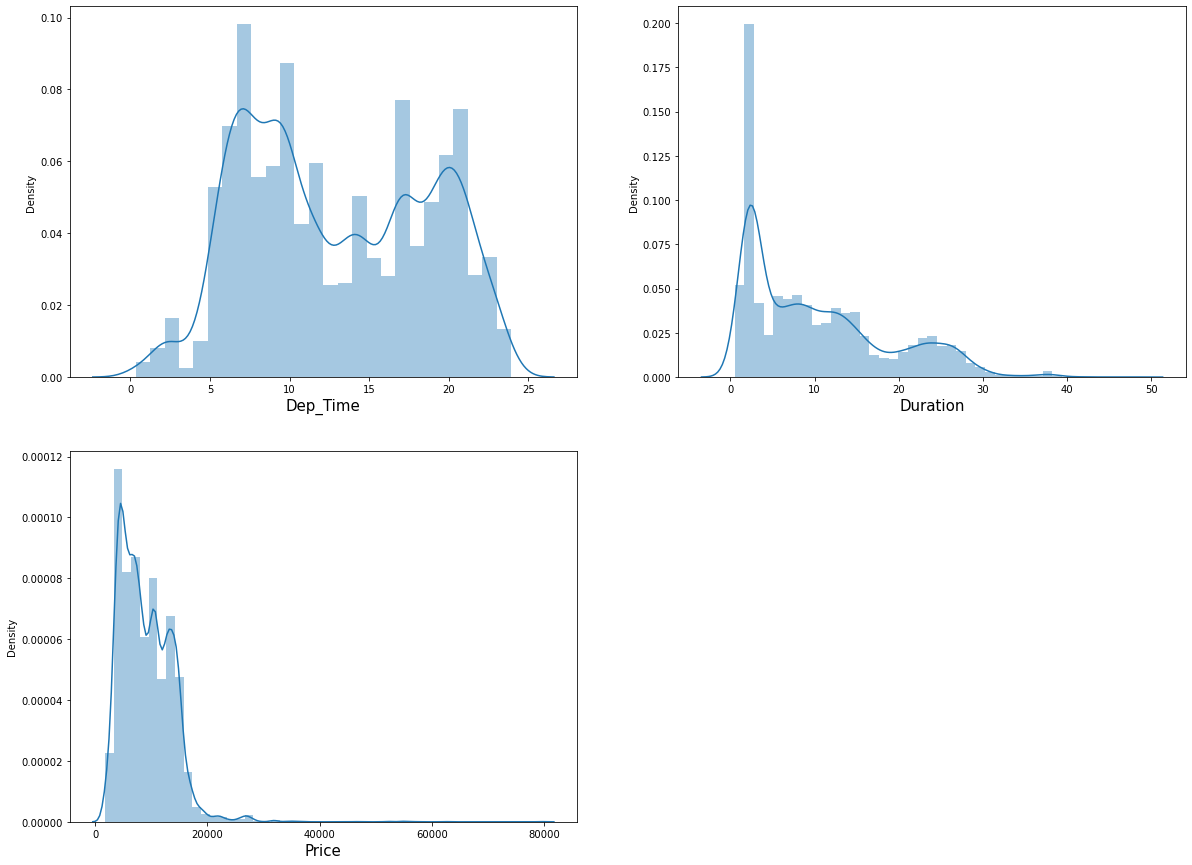

In [23]:
# Distribution plots of the columns with continuous data.
df_cont=df[['Dep_Time','Duration','Price']]
plt.figure(figsize=(20,15))
plotnumber=1
for column in df_cont:
    if plotnumber<=3:
        ax= plt.subplot(2,2,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=15)
    plotnumber+=1
plt.show()

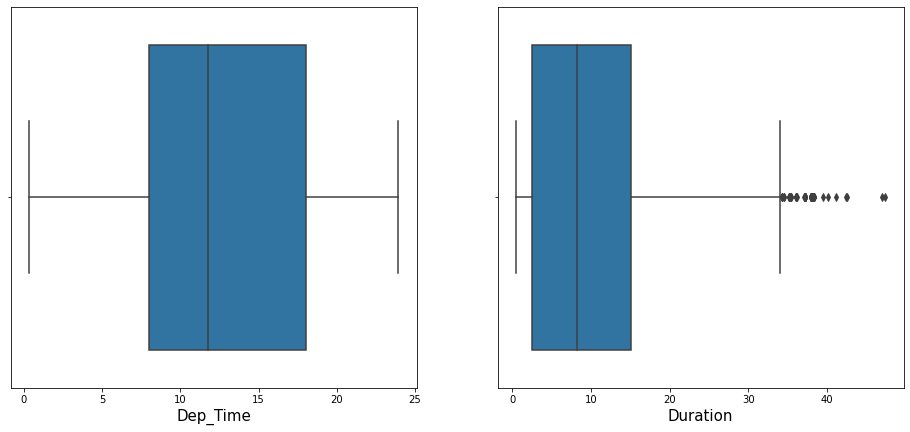

In [24]:
# Now let's see the box-plots of the continuous data features. 
plt.figure(figsize=(16,7))
plotnumber=1
for column in df_cont:
    if plotnumber<=2:
        ax= plt.subplot(1,2,plotnumber)
        sns.boxplot(df[column])
        plt.xlabel(column,fontsize=15)
    plotnumber+=1
plt.show()

# 'Duration' column have some outliers.

In [25]:
# Removing outliers in 'Duration' column using z-score.
from scipy.stats import zscore
z_score= zscore(df[['Duration']])
abs_zscore= np.abs(z_score)
filtering_entry= (abs_zscore<3).all(axis=1)
df=df[filtering_entry]
df.shape

(10400, 11)

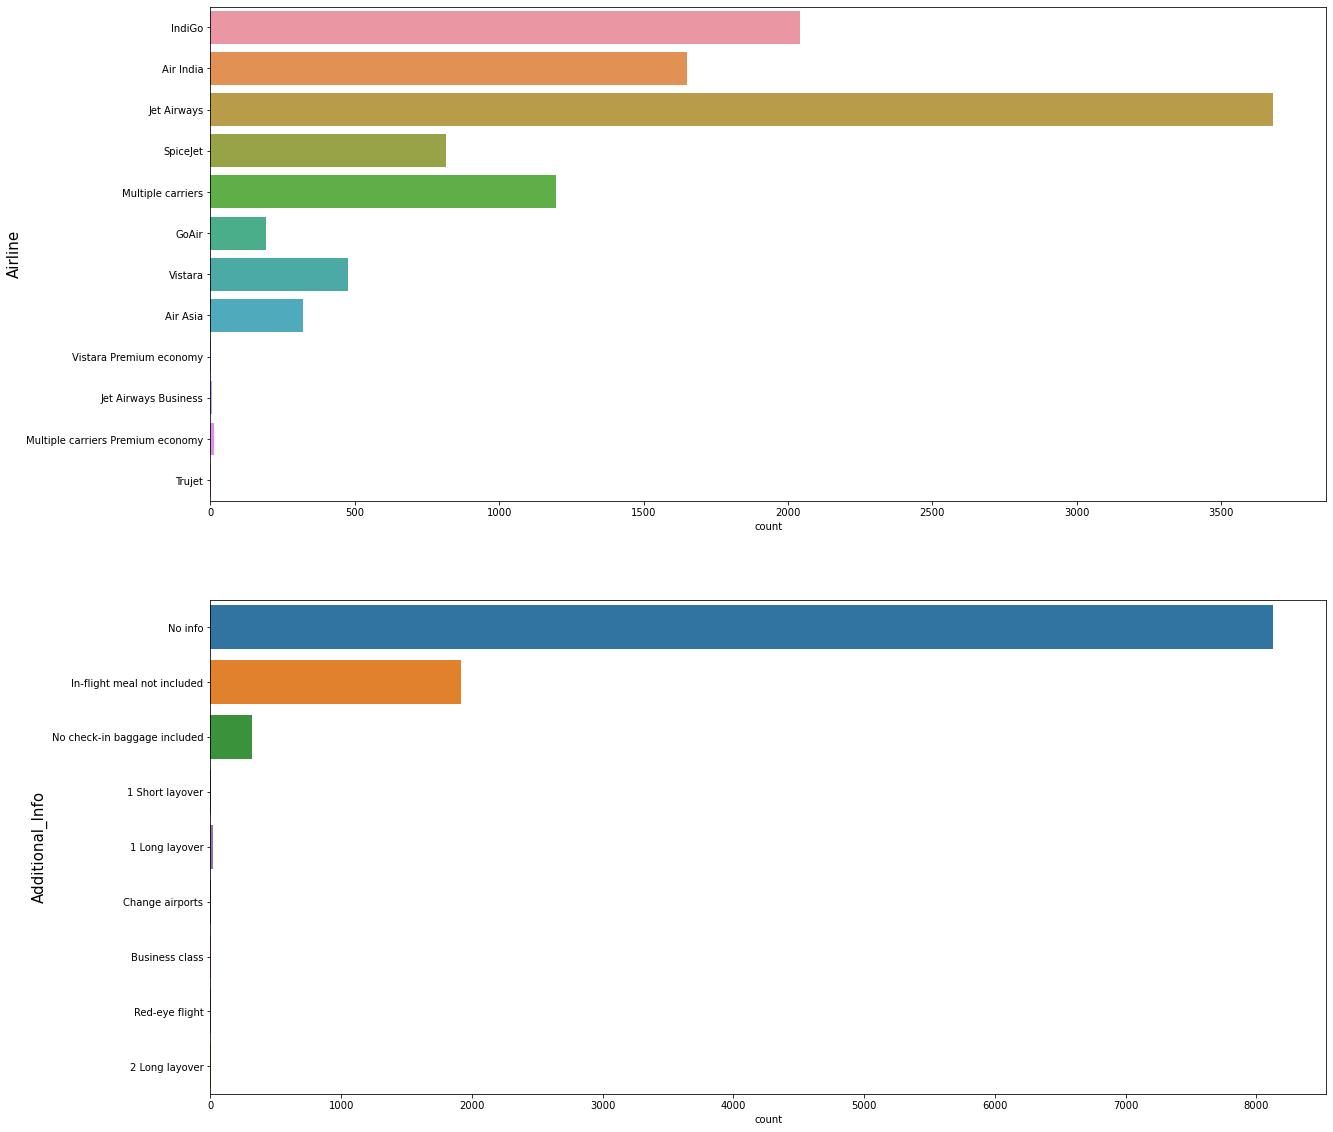

In [26]:
# Count plots of some of the categorical features.
df_cat1= df[['Airline','Additional_Info']]
plt.figure(figsize=(20,20))
plotnumber=1
for column in df_cat1:
    if plotnumber<=2:
        ax= plt.subplot(2,1,plotnumber)
        sns.countplot(y=df[column])
        plt.ylabel(column,fontsize=15)
    plotnumber+=1
plt.show()

# Majority of flights in the dataset are of Jet Airways.

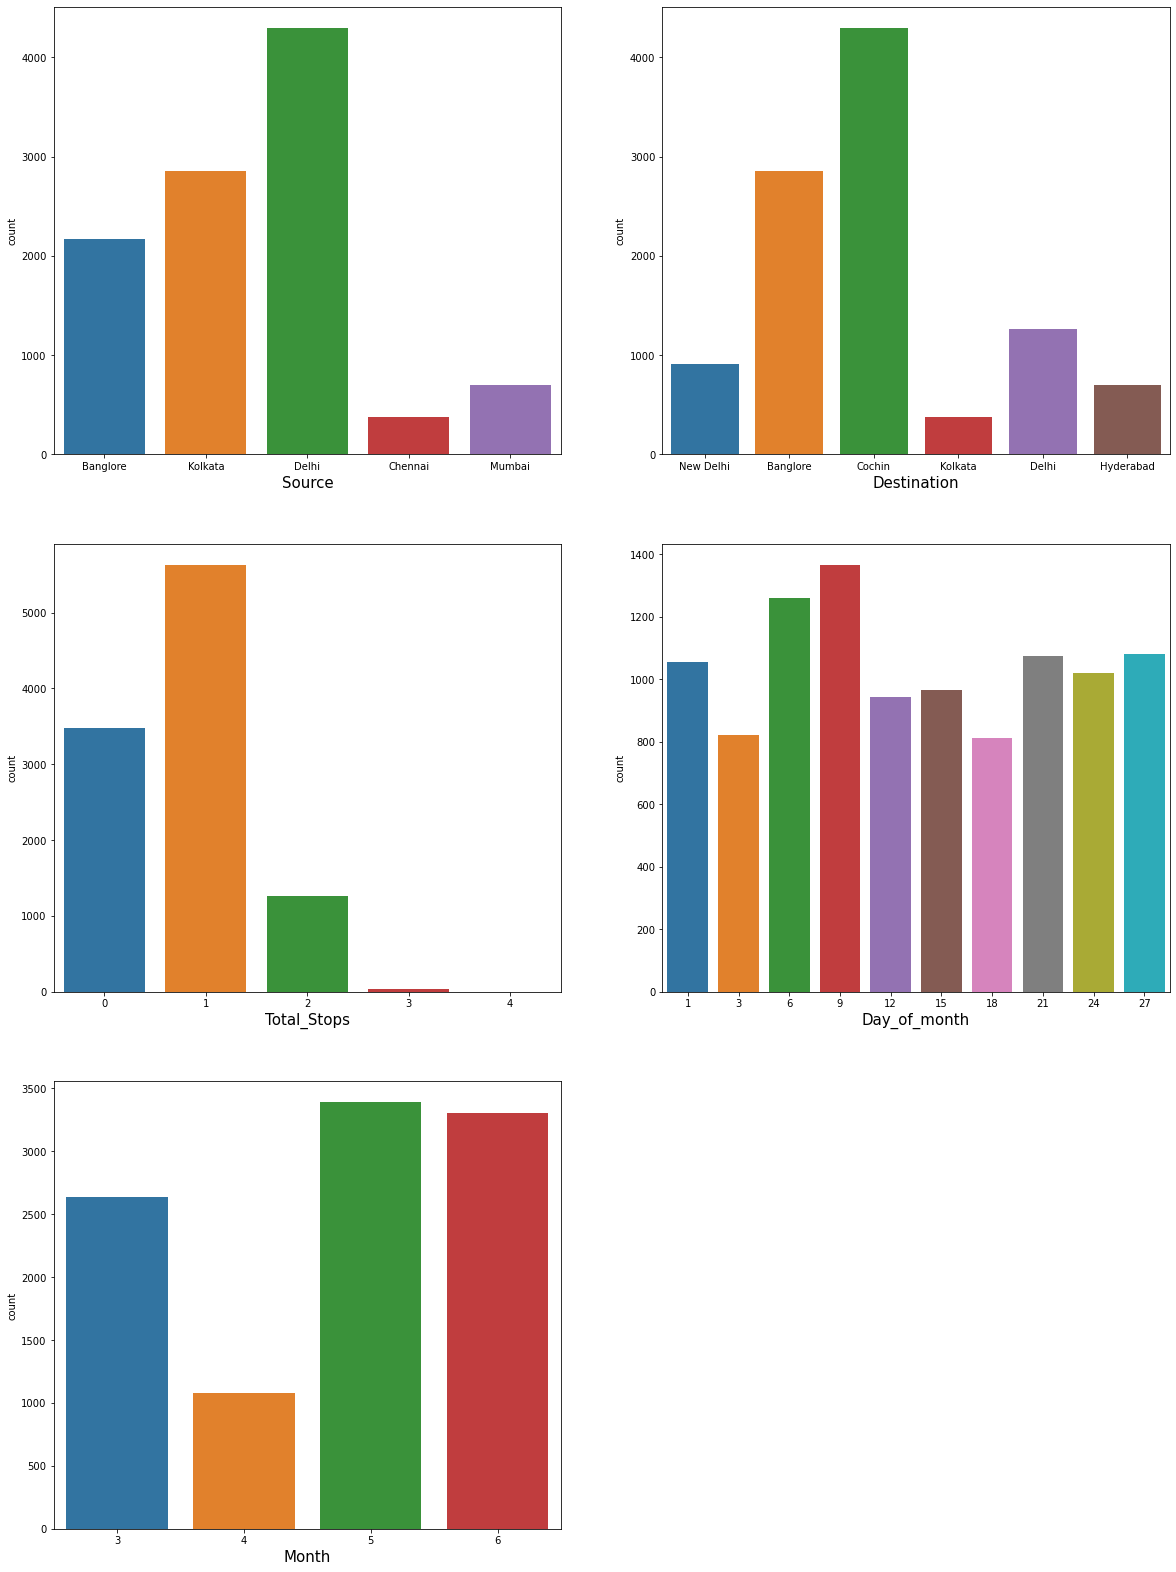

In [27]:
# Count plots of the other categorical features.
df_cat2=df[['Source', 'Destination', 'Total_Stops', 'Day_of_month', 'Month']]
plt.figure(figsize=(20,28))
plotnumber=1
for column in df_cat2:
    if plotnumber<=6:
        ax= plt.subplot(3,2,plotnumber)
        sns.countplot(df[column])
        plt.xlabel(column,fontsize=15)
    plotnumber+=1
plt.show()

# Delhi and Cochin are the most frequent source and destination.
# Most of the flights in this dataset have 1 stop during the journey.

Text(0, 0.5, 'Price')

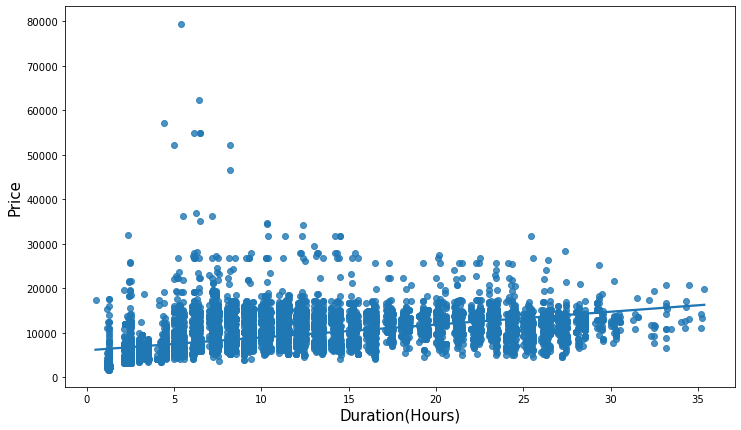

In [28]:
# Regplot of flight duration vs price.
plt.figure(figsize=(12,7))
sns.regplot(x='Duration',y='Price',data=df)
plt.xlabel("Duration(Hours)",fontsize=15)
plt.ylabel("Price",fontsize=15)

# A weak positive linear relation can be seen.

Text(0, 0.5, 'Price')

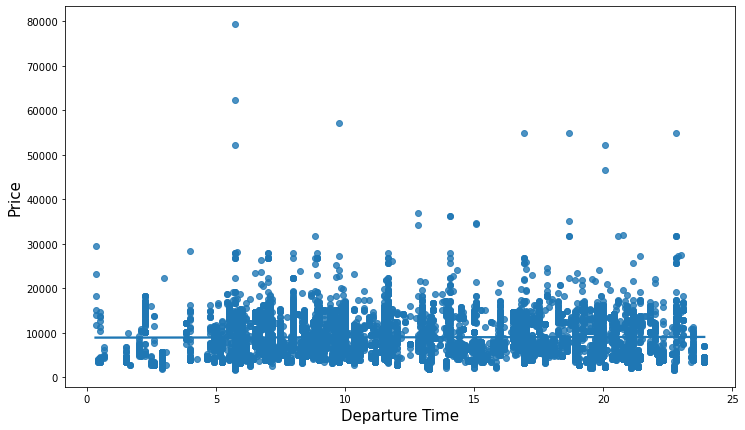

In [29]:
# Regplot of flight departure time vs price.
plt.figure(figsize=(12,7))
sns.regplot(x='Dep_Time',y='Price',data=df)
plt.xlabel("Departure Time",fontsize=15)
plt.ylabel("Price",fontsize=15)

# The regression fit line is almost horizontal. Hence we can say that they have almost no relation with each other.

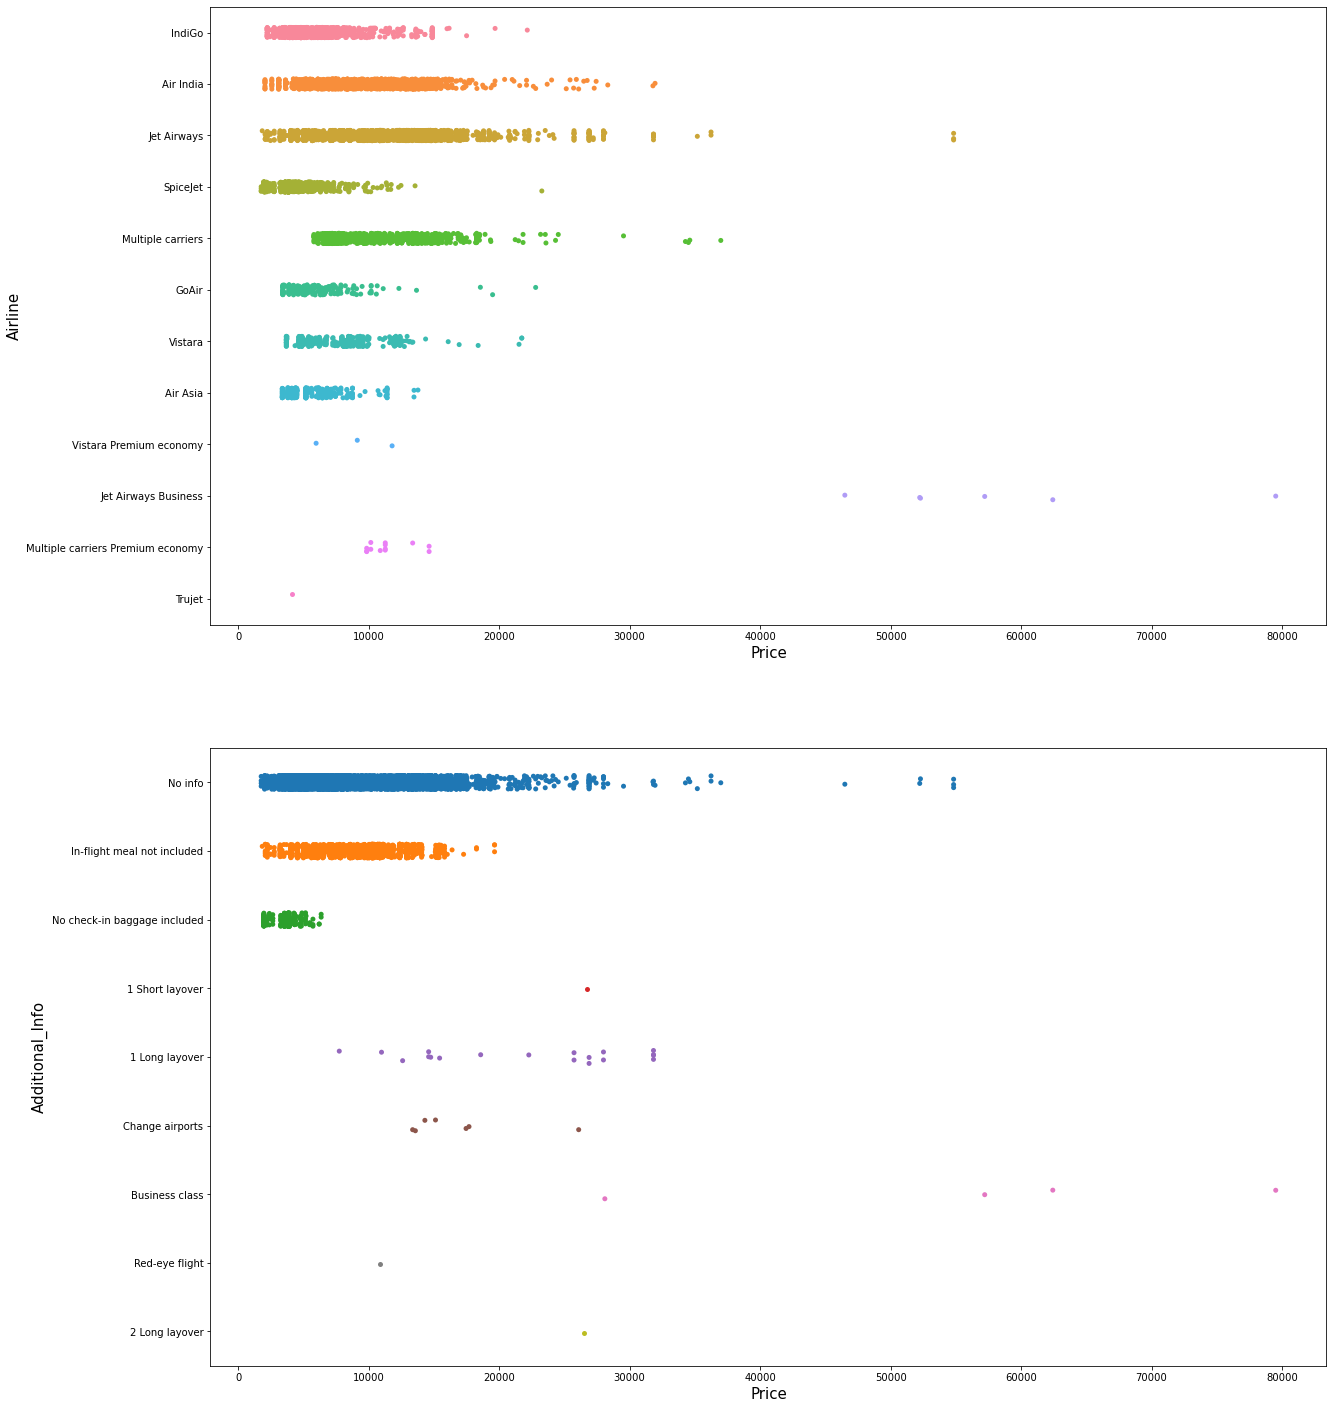

In [30]:
# Strip-plots of some categorical features with respect to the target variable i.e 'Price'.
plt.figure(figsize=(20,25))
for i in enumerate(df_cat1):
    plt.subplot(2,1,i[0]+1)
    sns.stripplot(x='Price',y=i[1],data=df)
    plt.ylabel(i[1],fontsize=15)
    plt.xlabel('Price',fontsize=15)
# Observations:
# 1. Multiple carriers have higher starting price among all except the Jet Airways Business class.
# 2. Jet Airways Business have the highest priced flights. 

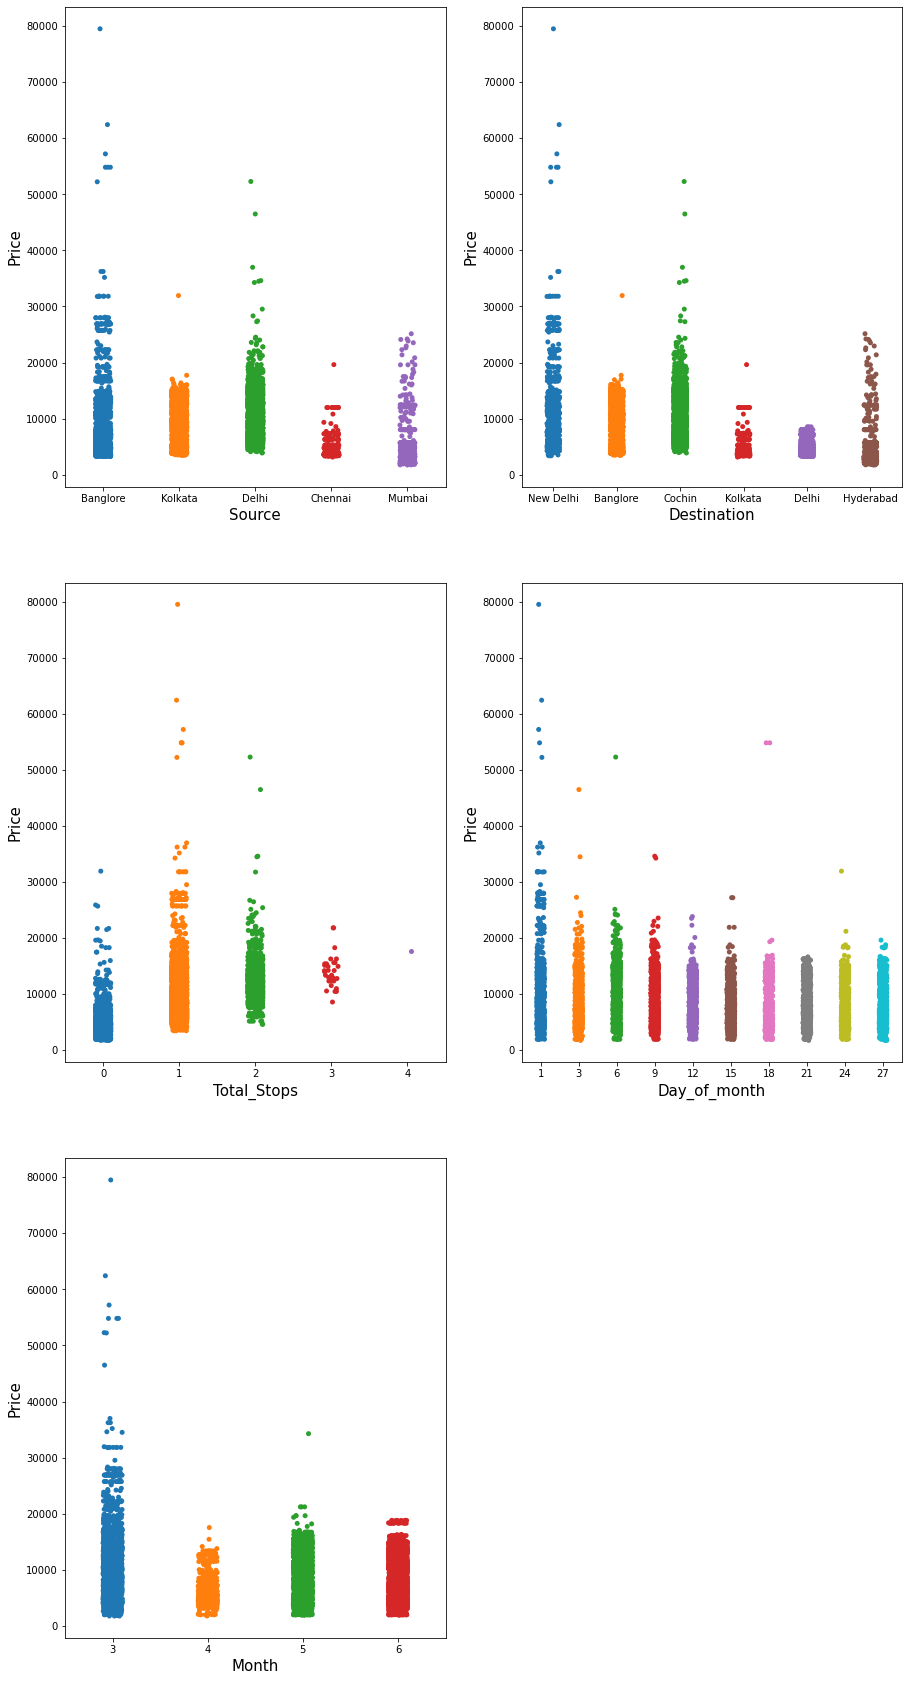

In [31]:
# Strip-plots of the other categorical features with respect to the target variable i.e 'Price'.
plt.figure(figsize=(15,30))
for i in enumerate(df_cat2):
    plt.subplot(3,2,i[0]+1)
    sns.stripplot(x=i[1],y='Price',data=df)
    plt.xlabel(i[1],fontsize=15)
    plt.ylabel('Price',fontsize=15)

# Encoding the categorical columns using Label Encoder

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10400 entries, 0 to 10462
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10400 non-null  object 
 1   Source           10400 non-null  object 
 2   Destination      10400 non-null  object 
 3   Route            10400 non-null  object 
 4   Dep_Time         10400 non-null  float64
 5   Duration         10400 non-null  float64
 6   Total_Stops      10400 non-null  int64  
 7   Additional_Info  10400 non-null  object 
 8   Price            10400 non-null  int64  
 9   Day_of_month     10400 non-null  int64  
 10  Month            10400 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 975.0+ KB


In [33]:
# Encoding the categorical columns with label encoder.
from sklearn.preprocessing import LabelEncoder
enc= LabelEncoder()

def label_encode(column):
    df[column]= enc.fit_transform(df[[column]])

df_to_encode=['Airline','Source','Destination','Route','Additional_Info']
for i in df_to_encode:
    label_encode(i)
df

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_month,Month
0,3,0,5,18,22.333333,2.50,0,7,3897,24,3
1,1,3,0,84,5.833333,7.25,2,7,7662,1,5
2,4,2,1,118,9.416667,19.00,2,7,13882,9,6
3,3,3,0,91,18.083333,5.25,1,7,6218,12,5
4,3,0,5,29,16.833333,4.45,1,7,13302,1,3
...,...,...,...,...,...,...,...,...,...,...,...
10458,0,3,0,64,19.916667,2.30,0,7,4107,9,4
10459,1,3,0,64,20.750000,2.35,0,7,4145,27,4
10460,4,0,2,18,8.333333,3.00,0,7,7229,27,4
10461,10,0,5,18,11.500000,2.40,0,7,12648,1,3


# Correlation

<AxesSubplot:>

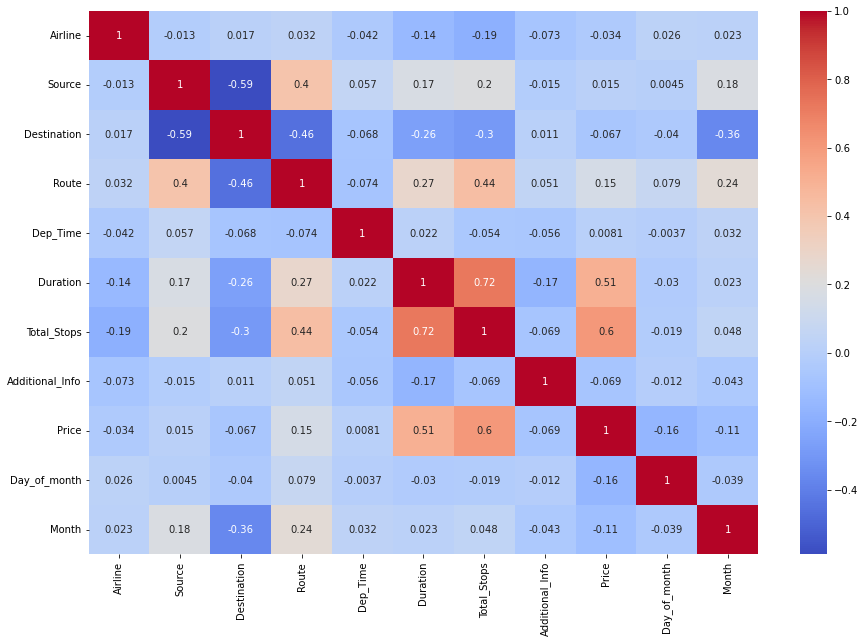

In [34]:
# Let's see the correlation heat-map.
corr=df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap="coolwarm")

# 'Total_stops' and 'Duration' might have a multicollinearity issue.

<AxesSubplot:xlabel='Total_Stops', ylabel='Duration'>

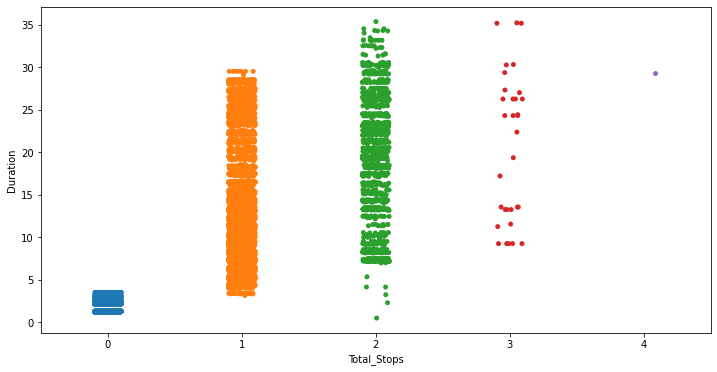

In [35]:
# Let's see the stripplot of 'Duration' vs 'Total_Stops'
plt.figure(figsize=(12,6))
sns.stripplot(x='Total_Stops',y='Duration',data=df)

# Data Transformation using Power Transformer

In [36]:
# Check skewness.
df[['Dep_Time','Duration']].skew()

# 'Duration' column have some skewness.

Dep_Time    0.114044
Duration    0.805934
dtype: float64

In [37]:
# Using power transformer to remove skewness.
from sklearn.preprocessing import PowerTransformer
pt= PowerTransformer(method="box-cox")

df['Duration']= pt.fit_transform(df[['Duration']])
df['Duration'].skew()

-0.05408918849253995

# Feature Selection 

In [38]:
# Check the correlation of the target variable with the columns.
np.abs(corr["Price"]).sort_values(ascending= False)

# 'Dep_Time' have very weak relation with 'Price'

Price              1.000000
Total_Stops        0.604082
Duration           0.507573
Day_of_month       0.157495
Route              0.153866
Month              0.109124
Additional_Info    0.069009
Destination        0.067116
Airline            0.033820
Source             0.014522
Dep_Time           0.008122
Name: Price, dtype: float64

In [39]:
# drop the 'Dep_Time' column.
df.drop(columns=['Dep_Time'],inplace=True)

In [40]:
# Separating the features and label.
X= df.drop(columns=['Price'])
y= df['Price']

In [41]:
# applying standard scaler on the features and scaling them.
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

In [42]:
# checking the variance-inflation-factor among our features.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"]=[variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"]= X.columns
print(vif)

# No multicollinearity issues can be seen.

        vif         Features
0  1.066830          Airline
1  1.655910           Source
2  2.002860      Destination
3  1.592264            Route
4  3.354009         Duration
5  3.430826      Total_Stops
6  1.075070  Additional_Info
7  1.020297     Day_of_month
8  1.203172            Month


# Regression Algorithms and their performance evaluation

In [43]:
############################################### LINEAR REGRESSION ##############################################################

from sklearn.linear_model import LinearRegression
lr= LinearRegression()

for i in range(0,10):
    x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=i)
    
    lr.fit(x_train,y_train)

    y_pred_train = lr.predict(x_train)
    accuracy_train = r2_score(y_train,y_pred_train)
    print("Training Score for sample",i,":",round(accuracy_train*100,2))

    y_pred= lr.predict(x_test)
    accuracy_test = r2_score(y_test,y_pred)
    print("Testing Score for sample",i,":",round(accuracy_test*100,2))

    print("Mean Absolute Error",round(mean_absolute_error(y_test,y_pred),2))
    print("Root Mean Squared Error",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))
    print("\n")

Training Score for sample 0 : 45.86
Testing Score for sample 0 : 45.12
Mean Absolute Error 2317.93
Root Mean Squared Error 3391.3


Training Score for sample 1 : 45.34
Testing Score for sample 1 : 47.36
Mean Absolute Error 2393.04
Root Mean Squared Error 3132.12


Training Score for sample 2 : 45.41
Testing Score for sample 2 : 46.96
Mean Absolute Error 2411.62
Root Mean Squared Error 3310.4


Training Score for sample 3 : 46.01
Testing Score for sample 3 : 44.49
Mean Absolute Error 2372.2
Root Mean Squared Error 3473.54


Training Score for sample 4 : 44.87
Testing Score for sample 4 : 49.1
Mean Absolute Error 2362.96
Root Mean Squared Error 3284.94


Training Score for sample 5 : 46.97
Testing Score for sample 5 : 40.99
Mean Absolute Error 2431.28
Root Mean Squared Error 3689.36


Training Score for sample 6 : 45.52
Testing Score for sample 6 : 46.55
Mean Absolute Error 2417.39
Root Mean Squared Error 3316.94


Training Score for sample 7 : 45.11
Testing Score for sample 7 : 48.13
Me

In [44]:
############################################### ADABOOST REGRESSION ############################################################

from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()

for i in range(0,10):
    x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=i)
    
    ada.fit(x_train, y_train)

    y_pred_train = ada.predict(x_train)
    accuracy_train = r2_score(y_train,y_pred_train)
    print("Training Score for sample",i,":",round(accuracy_train*100,2))

    y_pred= ada.predict(x_test)
    accuracy_test = r2_score(y_test,y_pred)
    print("Testing Score for sample",i,":",round(accuracy_test*100,2))

    print("Mean Absolute Error",round(mean_absolute_error(y_test,y_pred),2))
    print("Root Mean Squared Error",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))
    print("\n")

Training Score for sample 0 : 57.98
Testing Score for sample 0 : 54.75
Mean Absolute Error 2211.84
Root Mean Squared Error 3079.49


Training Score for sample 1 : 57.27
Testing Score for sample 1 : 52.91
Mean Absolute Error 2292.89
Root Mean Squared Error 2962.47


Training Score for sample 2 : 54.78
Testing Score for sample 2 : 50.45
Mean Absolute Error 2405.17
Root Mean Squared Error 3199.79


Training Score for sample 3 : 59.07
Testing Score for sample 3 : 59.55
Mean Absolute Error 2243.42
Root Mean Squared Error 2965.07


Training Score for sample 4 : 59.83
Testing Score for sample 4 : 54.71
Mean Absolute Error 2264.41
Root Mean Squared Error 3098.63


Training Score for sample 5 : 57.74
Testing Score for sample 5 : 51.25
Mean Absolute Error 2311.91
Root Mean Squared Error 3353.19


Training Score for sample 6 : 55.13
Testing Score for sample 6 : 48.42
Mean Absolute Error 2376.51
Root Mean Squared Error 3258.33


Training Score for sample 7 : 47.77
Testing Score for sample 7 : 40.9

In [45]:
############################################## RANDOM FOREST REGRESSION ########################################################

from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor(n_jobs=-1)

for i in range(0,10):
    x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=i)
   
    rf.fit(x_train,y_train)

    y_pred_train = rf.predict(x_train)
    accuracy_train = r2_score(y_train,y_pred_train)
    print("Training Score for sample",i,":",round(accuracy_train*100,2))

    y_pred= rf.predict(x_test)
    accuracy_test = r2_score(y_test,y_pred)
    print("Testing Score for sample",i,":",round(accuracy_test*100,2))

    print("Mean Absolute Error",round(mean_absolute_error(y_test,y_pred),2))
    print("Root Mean Squared Error",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))
    print("\n")

Training Score for sample 0 : 96.13
Testing Score for sample 0 : 85.0
Mean Absolute Error 793.27
Root Mean Squared Error 1772.99


Training Score for sample 1 : 96.05
Testing Score for sample 1 : 90.35
Mean Absolute Error 739.96
Root Mean Squared Error 1341.14


Training Score for sample 2 : 97.05
Testing Score for sample 2 : 82.28
Mean Absolute Error 823.27
Root Mean Squared Error 1913.66


Training Score for sample 3 : 96.88
Testing Score for sample 3 : 80.85
Mean Absolute Error 813.25
Root Mean Squared Error 2040.2


Training Score for sample 4 : 96.84
Testing Score for sample 4 : 83.57
Mean Absolute Error 779.38
Root Mean Squared Error 1866.47


Training Score for sample 5 : 96.68
Testing Score for sample 5 : 81.37
Mean Absolute Error 791.61
Root Mean Squared Error 2073.18


Training Score for sample 6 : 96.43
Testing Score for sample 6 : 85.42
Mean Absolute Error 759.11
Root Mean Squared Error 1732.2


Training Score for sample 7 : 96.24
Testing Score for sample 7 : 82.41
Mean Abs

In [46]:
######################################### XTREME-GRADIENT BOOST REGRESSION #####################################################

import xgboost as xgb
xgb_reg= xgb.XGBRegressor()

for i in range(0,10):
    x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=i)
    
    xgb_reg.fit(x_train,y_train)

    y_pred_train = xgb_reg.predict(x_train)
    accuracy_train = r2_score(y_train,y_pred_train)
    print("Training Score for sample",i,":",round(accuracy_train*100,2))

    y_pred= xgb_reg.predict(x_test)
    accuracy_test = r2_score(y_test,y_pred)
    print("Testing Score for sample",i,":",round(accuracy_test*100,2))

    print("Mean Absolute Error",round(mean_absolute_error(y_test,y_pred),2))
    print("Root Mean Squared Error",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))
    print("\n")

Training Score for sample 0 : 94.72
Testing Score for sample 0 : 83.52
Mean Absolute Error 834.94
Root Mean Squared Error 1858.45


Training Score for sample 1 : 94.36
Testing Score for sample 1 : 90.9
Mean Absolute Error 796.37
Root Mean Squared Error 1302.37


Training Score for sample 2 : 95.8
Testing Score for sample 2 : 83.97
Mean Absolute Error 850.83
Root Mean Squared Error 1820.11


Training Score for sample 3 : 95.46
Testing Score for sample 3 : 81.44
Mean Absolute Error 858.25
Root Mean Squared Error 2008.34


Training Score for sample 4 : 95.45
Testing Score for sample 4 : 85.34
Mean Absolute Error 813.68
Root Mean Squared Error 1762.85


Training Score for sample 5 : 94.8
Testing Score for sample 5 : 87.1
Mean Absolute Error 799.64
Root Mean Squared Error 1724.91


Training Score for sample 6 : 95.39
Testing Score for sample 6 : 85.05
Mean Absolute Error 817.22
Root Mean Squared Error 1754.35


Training Score for sample 7 : 94.59
Testing Score for sample 7 : 88.26
Mean Abso

In [47]:
############################################## K-NEIGHBORS REGRESSION ##########################################################

from sklearn.neighbors import KNeighborsRegressor
knr= KNeighborsRegressor()

for i in range(0,10):
    x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=i)
   
    knr.fit(x_train,y_train)

    y_pred_train = knr.predict(x_train)
    accuracy_train = r2_score(y_train,y_pred_train)
    print("Training Score for sample",i,":",round(accuracy_train*100,2))

    y_pred= knr.predict(x_test)
    accuracy_test = r2_score(y_test,y_pred)
    print("Testing Score for sample",i,":",round(accuracy_test*100,2))

    print("Mean Absolute Error",round(mean_absolute_error(y_test,y_pred),2))
    print("Root Mean Squared Error",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))
    print("\n")

Training Score for sample 0 : 86.22
Testing Score for sample 0 : 80.15
Mean Absolute Error 1094.32
Root Mean Squared Error 2039.65


Training Score for sample 1 : 87.06
Testing Score for sample 1 : 81.95
Mean Absolute Error 1063.33
Root Mean Squared Error 1833.97


Training Score for sample 2 : 87.38
Testing Score for sample 2 : 78.83
Mean Absolute Error 1116.1
Root Mean Squared Error 2091.64


Training Score for sample 3 : 87.94
Testing Score for sample 3 : 77.0
Mean Absolute Error 1110.86
Root Mean Squared Error 2235.92


Training Score for sample 4 : 87.43
Testing Score for sample 4 : 81.24
Mean Absolute Error 1061.37
Root Mean Squared Error 1994.14


Training Score for sample 5 : 87.07
Testing Score for sample 5 : 75.51
Mean Absolute Error 1098.6
Root Mean Squared Error 2376.52


Training Score for sample 6 : 87.37
Testing Score for sample 6 : 79.37
Mean Absolute Error 1080.54
Root Mean Squared Error 2060.48


Training Score for sample 7 : 86.36
Testing Score for sample 7 : 80.21
M

# Cross-Validation

In [48]:
# cross-validating the linear regression model.
for i in range(5,11):
    cv_score= cross_val_score(lr,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", round(cv_score*100,2))

the cv score for 5 fold: 45.57
the cv score for 6 fold: 45.78
the cv score for 7 fold: 45.79
the cv score for 8 fold: 45.72
the cv score for 9 fold: 45.86
the cv score for 10 fold: 45.9


In [49]:
# cross-validating the adaboost regression model.
for i in range(5,11):
    cv_score= cross_val_score(ada,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", round(cv_score*100,2))

the cv score for 5 fold: 50.43
the cv score for 6 fold: 48.61
the cv score for 7 fold: 49.19
the cv score for 8 fold: 42.16
the cv score for 9 fold: 48.28
the cv score for 10 fold: 48.54


In [50]:
# cross-validating the random-forests regression model.
for i in range(5,11):
    cv_score= cross_val_score(rf,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", round(cv_score*100,2))

the cv score for 5 fold: 85.23
the cv score for 6 fold: 85.27
the cv score for 7 fold: 84.73
the cv score for 8 fold: 85.51
the cv score for 9 fold: 85.26
the cv score for 10 fold: 85.65


In [51]:
# cross-validating the xgboost regression model.
for i in range(5,11):
    cv_score= cross_val_score(xgb_reg,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", round(cv_score*100,2))

the cv score for 5 fold: 87.87
the cv score for 6 fold: 87.16
the cv score for 7 fold: 87.65
the cv score for 8 fold: 88.26
the cv score for 9 fold: 87.57
the cv score for 10 fold: 88.08


In [52]:
# cross-validating the knn regression model.
for i in range(5,11):
    cv_score= cross_val_score(knr,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", round(cv_score*100,2))

the cv score for 5 fold: 80.16
the cv score for 6 fold: 80.52
the cv score for 7 fold: 80.34
the cv score for 8 fold: 79.84
the cv score for 9 fold: 80.56
the cv score for 10 fold: 80.67


In [ ]:
# In train-test split results XGBoost and Random-Forests are giving the best results.
# XGBoost regression model is giving the best accuracy in cross-validation results.
# Since XGBoost is performing better in cross-validation, hence lets move ahead with it and try to tune it further.

# Hyperparameter Tuning

In [53]:
import xgboost as xgb
xgb_reg= xgb.XGBRegressor(n_estimators=500,learning_rate=0.1,max_depth=5)

x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=1)
xgb_reg.fit(x_train,y_train)
y_pred_train = xgb_reg.predict(x_train)
accuracy_train = r2_score(y_train,y_pred_train)
print("Training Score:",round(accuracy_train*100,2))
y_pred= xgb_reg.predict(x_test)
accuracy_test = r2_score(y_test,y_pred)
print("Testing Score:",round(accuracy_test*100,2))

Training Score: 93.96
Testing Score: 91.28


In [54]:
from sklearn.model_selection import GridSearchCV

params= {"n_estimators": [250,500],
         "max_depth": [5,6],
         "learning_rate": [0.1,1]
         }

grd= GridSearchCV(xgb_reg, param_grid=params,cv=5,n_jobs=-1)
grd.fit(x_train,y_train)
print("Best Parameters:",grd.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [55]:
# Performance of the tuned model.
xgb_tuned= grd.best_estimator_
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=1)

xgb_tuned.fit(x_train,y_train)
y_pred_train = xgb_tuned.predict(x_train)
accuracy_train = r2_score(y_train,y_pred_train)
y_pred= xgb_tuned.predict(x_test)
accuracy_test = r2_score(y_test,y_pred)

print("Training Score for best sample",round(accuracy_train*100,2))
print("Testing Score for best sample:",round(accuracy_test*100,2))
print("Mean Absolute Error",round(mean_absolute_error(y_test,y_pred),2))
print("Root Mean Squared Error",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))

# cross-validating the random forests regression model.
print("\n++++++++++++++ CROSS VALIDATION ++++++++++++++++","\n")
for i in range(5,11):
    cv_score= cross_val_score(xgb_tuned,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", round(cv_score*100,2))

Training Score for best sample 93.96
Testing Score for best sample: 91.28
Mean Absolute Error 777.94
Root Mean Squared Error 1274.55

++++++++++++++ CROSS VALIDATION ++++++++++++++++ 

the cv score for 5 fold: 88.9
the cv score for 6 fold: 88.8
the cv score for 7 fold: 88.23
the cv score for 8 fold: 89.0
the cv score for 9 fold: 89.27
the cv score for 10 fold: 89.15


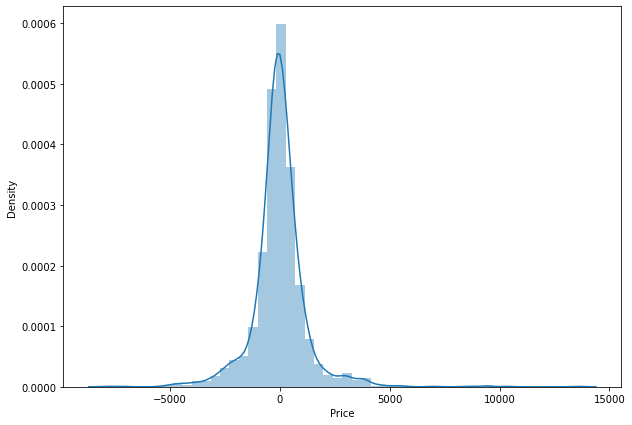

In [57]:
# Distribution plot of difference between actual and predicted values.
y_diff= y_test-y_pred
plt.figure(figsize=(10,7))
sns.distplot(y_diff)
plt.show()

# Test data prediction

In [82]:
# get the test data and save it in a dataframe.
df_test= pd.read_excel("Test_set_Flight_Price_Prediction.xlsx")
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [83]:
df_test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

Repeating the steps we did during model building:

In [84]:
# Convert the 'Date_of_Journey' column to datetime format and extract the Day and Month into separate columns.
df_test['Date_of_Journey']=pd.to_datetime(df_test['Date_of_Journey'],format='%d/%m/%Y',dayfirst=True)
df_test['Day_of_month']= df_test['Date_of_Journey'].dt.day
df_test['Month']= df_test['Date_of_Journey'].dt.month
df_test.drop(columns=['Date_of_Journey'],inplace=True)
# drop the 'Arrival_Time' column as we already have departure time and flight duration.
df_test.drop(columns=['Arrival_Time'],inplace=True)
# Convert the 'Dep_Time' column to datetime format and convert it to 24 hours format of float-datatype
df_test['Dep_Time']=pd.to_datetime(df_test['Dep_Time'],format='%H:%M')
x=df_test['Dep_Time'].dt.hour+df_test['Dep_Time'].dt.minute/60
df_test['Dep_Time']=x
# The h and m in duration data is removed and only numerics are extracted to a list in string format.
duratn=[]
for i in range(len(df_test['Duration'])):
    components= df_test['Duration'][i].strip().split(" ")
    if len(components)==2:
        hour= components[0].split("h")[0]
        minute=components[1].split("m")[0]
        duratn.append(hour+'.'+minute)
    elif (len(components)==1) & (components[0].find("h")!=(-1)):
        hour= components[0].split("h")[0]
        minute=str(0)
        duratn.append(hour+'.'+minute)
    elif (len(components)==1) & (components[0].find("m")!=(-1)):
        hour=str(0)
        minute=components[0].split("m")[0]
        duratn.append(hour+'.'+minute)
    else:
        duratn.append(df_test['Duration'][i])
# duration data is converted to numeric format.
df_test['Duration']= pd.to_numeric(duratn)
# encoding the data using replace function.
df_test['Total_Stops'].replace({'non-stop':0, 
                           '1 stop':1, 
                           '2 stops':2, 
                           '3 stops':3, 
                           '4 stops':4},inplace=True)
df_test['Additional_Info'].replace("No Info","No info",inplace=True)
# Encoding
def label_encode(column):
    df_test[column]= enc.fit_transform(df_test[[column]])
df_test_to_encode=['Airline','Source','Destination','Route','Additional_Info']
for i in df_test_to_encode:
    label_encode(i)
# power transformation
df_test['Duration']= pt.fit_transform(df_test[['Duration']])
# drop the 'Dep_Time' column.
df_test.drop(columns=['Dep_Time'],inplace=True)
# applying standard scaler on the features and scaling them.
df_scaled= scaler.fit_transform(df_test)
df_scaled

array([[ 0.01190758,  0.03256662, -0.29488167, ...,  0.48039397,
        -0.83733254,  1.09474457],
       [-0.42377921,  0.87708559, -0.97622158, ...,  0.48039397,
        -0.11087675,  0.2405048 ],
       [ 0.01190758,  0.03256662, -0.29488167, ..., -2.14897547,
         0.97880692,  0.2405048 ],
       ...,
       [ 0.01190758,  0.03256662, -0.29488167, ...,  0.48039397,
        -0.83733254, -1.46797475],
       [-1.29515278,  0.03256662, -0.29488167, ...,  0.48039397,
        -0.83733254, -1.46797475],
       [ 0.88328115,  0.03256662, -0.29488167, ...,  0.48039397,
         0.25235114,  1.09474457]])

In [85]:
# Prediction using our model.
predictions= xgb_tuned.predict(df_scaled)
predictions

array([14338.117 ,  4280.0547, 11491.573 , ..., 16834.906 , 12067.314 ,
       10893.883 ], dtype=float32)

In [86]:
len(predictions)

2671

In [87]:
predictions_df= pd.DataFrame({'Price':predictions})
predictions_df

,Price
0,14338.117188
1,4280.054688
2,11491.573242
3,10068.073242
4,3635.210449
...,...
2666,7025.796875
2667,5489.521484
2668,16834.906250
2669,12067.314453


In [88]:
predictions_df.to_excel("Predictions.xlsx")

# Saving the model using pickle

In [89]:
# saving the tuned xgboost model using pickle.
import pickle 

Flight_Price= "Flight_Price_model.pickle"
pickle.dump(xgb_tuned, open(Flight_Price,'wb'))